<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Libraries" data-toc-modified-id="Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Exercises" data-toc-modified-id="Exercises-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exercises</a></span><ul class="toc-item"><li><span><a href="#The-Dice-Problem" data-toc-modified-id="The-Dice-Problem-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>The Dice Problem</a></span><ul class="toc-item"><li><span><a href="#Exercise-1-&amp;-2" data-toc-modified-id="Exercise-1-&amp;-2-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Exercise 1 &amp; 2</a></span></li></ul></li></ul></li><li><span><a href="#The-German-Tank-Problem" data-toc-modified-id="The-German-Tank-Problem-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The German Tank Problem</a></span><ul class="toc-item"><li><span><a href="#Exercise-3" data-toc-modified-id="Exercise-3-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Exercise 3</a></span></li></ul></li></ul></div>

# Introduction

 This notebook contains solutions to the [dice notebook](https://github.com/AllenDowney/BayesMadeSimple/blob/master/02_dice_soln.ipynb).

# Libraries

In [1]:
using Gen
using Statistics
using Plots
using DataStructures
using Printf

# Exercises

## The Dice Problem

I have a box of dice that contains:

* a 4-sided die
* a 6-sided die
* an 8-sided die
* a 12-sided die

Suppose I select a die from the box at random, roll it, and get a 6.

What is the probability that I rolled each die?

### Exercise 1 & 2
Answer the question posed in **The Dice Problem**

Model the problem:

In [2]:
int_to_die = Dict(1 => "4-sided", 
                  2 => "6-sided",
                  3 => "8-sided",
                  4 => "12-sided")

function extract_sides(die::String)
    side, _ = split(die, "-")
    return parse(Int, side)
end;

In [3]:
# # Attempt 1

# @gen function dice_select_roll(x::Any)
#     dice = @trace(categorical([0.25, 0.25, 0.25, 0.25]), :dice)
#     sides = extract_sides(int_to_die[dice])
#     roll = @trace(uniform_discrete(1, sides), :roll)
# end;

In [4]:
# # Attempt 2

# select_dice_probs = zeros(12)
# select_dice_probs[4] = 1/4
# select_dice_probs[6] = 1/4
# select_dice_probs[8] = 1/4
# select_dice_probs[12] = 1/4

# @gen function dice_select_roll(x::Any)
#     dice = @trace(categorical(select_dice_probs), :dice)
#     roll = @trace(uniform_discrete(1, dice), :roll)
# end;

In [5]:
# Attempt 3

function build_dice_probs(side::Integer, max_outcome=12)
    probs = zeros(max_outcome)
    epsilon = 1e-9
    
    real_prob = 1/side - epsilon/side
    fake_prob = epsilon/(max_outcome - side)
    
    for i in 1:side
        probs[i] = real_prob
    end
    
    for i in (side + 1):max_outcome
        probs[i] = fake_prob
    end
    return probs
end

@gen function dice_select_roll(x::Any)
    dice = @trace(categorical([0.25, 0.25, 0.25, 0.25]), :dice)
    sides = extract_sides(int_to_die[dice])
    dice_probs = build_dice_probs(sides)
    roll = @trace(categorical(dice_probs), :roll)
end;

Sample from the posterior:

In [6]:
dies = []
observations = Gen.choicemap(:roll => 6)

for _ in 1:100000
    (trace, _) = Gen.importance_resampling(dice_select_roll, (nothing,), observations, 100)
    push!(dies, trace[:dice])
end

Compute the probabilities:

In [7]:
c = counter(dies)

Accumulator{Any,Int64} with 3 entries:
  4 => 22431
  2 => 44375
  3 => 33194

In [8]:
total = sum(values(c))

for (k,v) in c.map
    die = int_to_die[k]
    prob = v/total
    
    out = @sprintf "%s: %.2f" die prob
    println(out)
end

12-sided: 0.22
6-sided: 0.44
8-sided: 0.33


If we have rolled 8, 7, 7, 5, 4:

In [9]:
@gen function dice_select_roll(rolls::Integer)
    dice = @trace(categorical([0.25, 0.25, 0.25, 0.25]), :dice)
    
    sides = extract_sides(int_to_die[dice])
    dice_probs = build_dice_probs(sides)
    
    for i in 1:rolls
        @trace(categorical(dice_probs), (:roll, i))
    end
end;

In [10]:
dies = []
observations = Gen.choicemap((:roll, 1) => 8,
                             (:roll, 2) => 7,
                             (:roll, 3) => 7,
                             (:roll, 4) => 5,
                             (:roll, 5) => 4)

for _ in 1:100000
    (trace, _) = Gen.importance_resampling(dice_select_roll, (5,), observations, 100)
    push!(dies, trace[:dice])
end

In [11]:
c = counter(dies)

total = sum(values(c))

for (k,v) in c.map
    die = int_to_die[k]
    prob = v/total
    
    out = @sprintf "%s: %.2f" die prob
    println(out)
end

12-sided: 0.12
8-sided: 0.88


# The German Tank Problem

**Question**

Serial numbers in blocks of 100.

Not all numbers used.

Capture a tank with number 42.

How many numbers in the blocks were used?

**Solution**

Build the model:

In [12]:
function build_outcomes(production::Integer, max_production::Integer=100)
    outcomes = zeros(max_production)
    epsilon = 1e-3
    
    real_prob = 1/production - (epsilon/production)
    fake_prob = epsilon/(max_production - production)
    
    for i in 1:production
        outcomes[i] = real_prob
    end
    
    for i in (production + 1):max_production
        outcomes[i] = fake_prob
    end
    
    return outcomes
        
end;

In [13]:
@gen function tank_serial_number(observed_tanks::Integer)
    tanks_produced = @trace(uniform_discrete(1, 100), :tanks_produced)
    outcome_probs = build_outcomes(tanks_produced)
    
    for i in 1:observed_tanks
        @trace(categorical(outcome_probs), (:obs, i))
    end
end;

Sample the posterior:

In [14]:
outcomes = Array{Int,1}()
observations = Gen.choicemap((:obs, 1) => 42)

for _ in 1:100000
    (trace, _) = Gen.importance_resampling(tank_serial_number, (1,), observations, 100)
    actual_production = trace[:tanks_produced]
    push!(outcomes, actual_production)
end

Compute the answer:

In [15]:
@sprintf "The expected number of tanks produced is %.2f" mean(outcomes)

"The expected number of tanks produced is 66.84"

Plot the posteriro distribution:

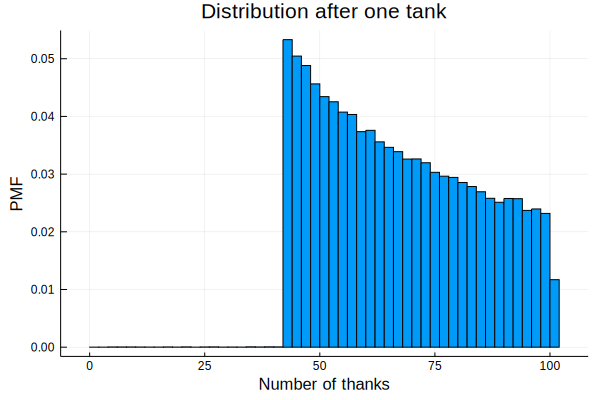

In [16]:
histogram(outcomes, 
          normalize=:probability, 
          legend=nothing, 
          xlabel="Number of thanks", 
          ylabel="PMF", 
          title="Distribution after one tank")

## Exercise 3

**Question**

Suppose we see another tank with serial number 17. What effect does this have on the posterior probabilities?

**Solution**

In [17]:
outcomes_2 = Array{Int,1}()
observations = Gen.choicemap((:obs, 1) => 42, (:obs, 2) => 17)

for _ in 1:100000
    (trace, _) = Gen.importance_resampling(tank_serial_number, (2,), observations, 100)
    actual_production = trace[:tanks_produced]
    push!(outcomes_2, actual_production)
end

In [18]:
@sprintf "The expected number of tanks produced is %.2f" mean(outcomes_2)

"The expected number of tanks produced is 62.72"

In [19]:
function build_series_for_plot(outcomes::Array{Int,1})::Tuple{Array{Int64,1},Array{Float64,1}}

    c = counter(outcomes)
    data = []
    total = sum(values(c))

    for (k,v) in c
       push!(data, (k, v/total))
    end

    sort!(data)

    xs, ys = zip(data...)
    
    return collect(xs), collect(ys)
end;

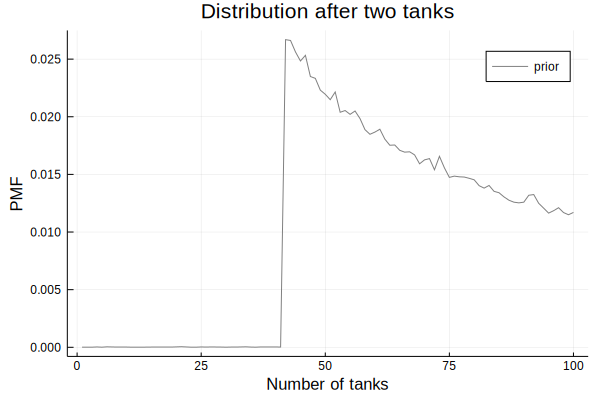

In [20]:
xs, ys = build_series_for_plot(outcomes)
plot(xs, 
     ys, 
     xlabel="Number of tanks", 
     ylabel="PMF", 
     label="prior", 
     color="grey", 
     title="Distribution after two tanks")

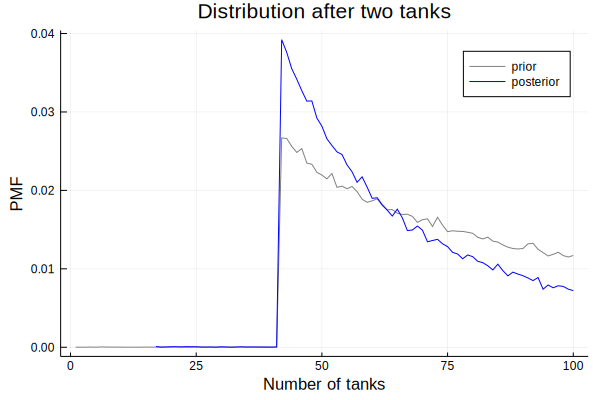

In [21]:
xs, ys = build_series_for_plot(outcomes_2)
plot!(xs, ys, xlabel="Number of tanks", ylabel="PMF", label="posterior", color="blue")